# Random Forest on Yearly Aggregates
<a id='top'></a>

<a href=#readdata>Read Data</a>  

<a href=#features>Feature Selection</a>

<a href=#dt>Random Forest</a>

<a href=#inspectfeatures>Inspect Features</a>

<a href=#dummy>One Hot Encode</a>

<a href=#balancedata>Balance Data</a>

<a href=#dt_rebalance>Random Forest on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#bottom>Bottom</a>


## Questions:

has_relocated_this_year

has_relocated_next_year has null values

reading in directly from bucket



In [23]:
# Ignore 'dask' warning
import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
from datetime import date
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.utils import resample
from sklearn import preprocessing
from scipy.stats import sem
import pickle

from matplotlib import pyplot
import seaborn as sns
from scipy import stats

<a id='readdata'></a>
# Read Yearly Aggregated Data 
<a href=#top>Top</a>

In [2]:

# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)


In [3]:

# Post-aggregation
def create_dict_types_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    dtype={ 
        'id_company'  :np.float64,
        'id_branch'    :np.int64, 
        'code_sbi_2'         : np.float64, 
        'has_relocated':bool,
        'has_relocated_next_year ' : bool,
        'has_name_change' : bool,
        'qty_address_mutations_total' :np.float64,
        'ratio_operating_result_consolidated_operating_result': np.float64,
        'ratio_revenue_consolidated_revenue': np.float64,
        'qty_green_flags'   :np.float64,
        'qty_orange_flags'   :np.float64,
        'qty_red_flags'   :np.float64,
        'A'   :np.float64,
        'AA'   :np.float64,
        'AAA'   :np.float64,
        'B'   :np.float64,
        'BB'   :np.float64,
        'BBB'   :np.float64,
        'C'   :np.float64,
        'CC'   :np.float64,
        'CCC'   :np.float64,
        'D'   :np.float64,
        'NR'   :np.float64,
        'code_legal_form_group_1':  np.int64,
        'code_legal_form_group_2':  np.int64,
        'SBI_group_1':  np.int64,
        'SBI_group_2':  np.int64,
        'company_age'   :np.float64,
        'years_since_last_amt_consolidated_operating_result'   :np.float64,
        'years_since_last_amt_consolidated_revenue'   :np.float64,
        'years_since_last_amt_operating_result'   :np.float64,
        'years_since_last_qty_employees'   :np.float64,
        'years_since_last_amt_revenue'   :np.float64,
        'delta_qty_employees'   :np.float64,
        'delta_qty_issued_credit_reports'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'SBI_has_changed' : bool,
        'unique_id' : object,
        'code_legal_form_has_changed ' : bool,
        'is_discontinued_any ' : bool,
        'has_financial_calamity ' : bool,
        'mean_amt_consolidated_operating_result'   :np.float64,
        'mean_amt_consolidated_revenue'   :np.float64,
        'mean_amt_operating_result'   :np.float64,
        'mean_amt_revenue'   :np.float64,
        'mean_qty_employees'   :np.float64,
        'mean_qty_issued_credit_reports'   :np.float64,
        'mean_score_payment_assessment'   :np.float64,
        'mean_score_pd'   :np.float64,
        'qty_address_mutations_year'   :np.float64,
        'qty_started_names_year'   :np.float64,
        'qty_stopped_names_year'   :np.float64,
        'qty_board_changes_year'   :np.float64,
        'variance_qty_employees'   :np.float64,
        'variance_qty_issued_credit_reports'   :np.float64,
        'variance_score_payment_assessment'   :np.float64,
        'variance_score_pd'   :np.float64
      }
    return dtype

def create_parse_dates_list_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    parse_dates= ['date_month', 'years_in_current_location']
    return parse_dates

def create_basetable(year_list, dir_prefix = ''):
    """ Reads a whole year of data from the already aggregated files and creates basetable """
    dtype = create_dict_types_aggregated_data()
    parse_dates = create_parse_dates_list_aggregated_data()
    basetable = pd.DataFrame()
    for year in year_list:
        full_year_df = pd.DataFrame()
        print('Starting with year: ', year)
        print(dir_prefix)
        blob_list = list(bucket.list_blobs(prefix=dir_prefix))    
        for blob in blob_list:  
            if year in blob.name:
                print('Processing file: ', blob.name)
                with fs.open('graydon-data/' + blob.name) as f:
                    full_year_df = pd.read_csv(f, sep=',', index_col=0, dtype=dtype, parse_dates=parse_dates 
                                            )   
                print('The number of rows of the year read is far is: ', full_year_df.shape[0])
        basetable = basetable.append(full_year_df)
    print('The final number of rows of the basetable created is: ', basetable.shape[0])
    return basetable

# Calling it
data_df = create_basetable(year_list = ['2013', '2014', '2015', '2016', '2017'], dir_prefix ='03_aggregated')

Starting with year:  2013
03_aggregated
Processing file:  03_aggregated/2013_aggregated.csv


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (4,58) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The number of rows of the year read is far is:  1811253
Starting with year:  2014
03_aggregated
Processing file:  03_aggregated/2014_aggregated.csv


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


The number of rows of the year read is far is:  1852836
Starting with year:  2015
03_aggregated
Processing file:  03_aggregated/2015_aggregated.csv
The number of rows of the year read is far is:  1890941
Starting with year:  2016
03_aggregated
Processing file:  03_aggregated/2016_aggregated.csv
The number of rows of the year read is far is:  1930102


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Starting with year:  2017
03_aggregated
Processing file:  03_aggregated/2017_aggregated.csv
The number of rows of the year read is far is:  1966208
The final number of rows of the basetable created is:  9451340


In [4]:
data_df.shape

(9451340, 58)

## Check Distribution of Target:

In [5]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    8606784
True      477269
Name: has_relocated_next_year, dtype: int64 
 False    0.910642
True     0.050497
Name: has_relocated_next_year, dtype: float64


In [6]:
sum(data_df.has_relocated_next_year.isna())

367287

In [7]:
data_df[data_df.has_relocated_next_year.isna()] = 0

In [8]:
sum(data_df.has_relocated_next_year.isna())

0

In [9]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    8974071
True      477269
Name: has_relocated_next_year, dtype: int64 
 False    0.949503
True     0.050497
Name: has_relocated_next_year, dtype: float64


In [32]:
HTML(DataFrame(data_df).head(10).to_html())

,Unnamed: 0,id_branch,id_company,date_month,code_sbi_1,has_relocated,has_name_change,delta_qty_employees,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,SBI_has_changed,company_age,years_since_last_amt_consolidated_operating_result,years_since_last_amt_consolidated_revenue,years_since_last_amt_operating_result,years_since_last_qty_employees,years_since_last_amt_revenue,years_in_current_location,ratio_operating_result_consolidated_operating_result,ratio_revenue_consolidated_revenue,unique_id,qty_green_flags,qty_orange_flags,qty_red_flags,A,AA,AAA,B,BB,BBB,C,CC,CCC,D,NR,code_legal_form_group_1,code_legal_form_group_2,SBI_group_1,SBI_group_2,is_discontinued_any,has_financial_calamity,mean_amt_consolidated_operating_result,mean_amt_consolidated_revenue,mean_amt_operating_result,mean_amt_revenue,mean_qty_employees,mean_qty_issued_credit_reports,mean_score_payment_assessment,mean_score_pd,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,variance_qty_employees,variance_qty_issued_credit_reports,variance_score_payment_assessment,variance_score_pd,has_relocated_next_year
0,0,0,428134.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_428134.0,0,0,12,0,0,0,12,0,0,0,0,0,0,0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
1,1,0,803351.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_803351.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
2,2,0,810695.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_810695.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
3,3,0,811258.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_811258.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
4,4,0,811333.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_811333.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
5,5,0,818258.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_818258.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
6,6,0,823722.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_823722.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
7,7,0,829630.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_829630.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
8,8,0,834432.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_834432.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
9,9,0,834909.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_834909.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False


In [10]:
data_df.shape

(9451340, 58)

<a id='features'></a>
# Feature Selection:

<a href=#top>Top</a>

In [11]:
print(data_df.isnull().sum())

A                                                             0
AA                                                            0
AAA                                                           0
B                                                             0
BB                                                            0
BBB                                                           0
C                                                             0
CC                                                            0
CCC                                                           0
D                                                             0
NR                                                            0
SBI_group_1                                                   0
SBI_group_2                                                   0
SBI_has_changed                                               0
code_legal_form_group_1                                       0
code_legal_form_group_2                 

In [12]:
features_to_exclude = ('id_branch',
                       'id_company',
                       'date_month',
                       'unique_id',
                       'code_sbi_1',
                       'has_relocated',
                       #'has_name_change',
                       'delta_qty_employees',
                       #'delta_qty_issued_credit_reports', 
                       #'delta_score_payment_assessment',
                       #'code_legal_form_has_changed',
                       #'SBI_has_changed',
                       #'company_age',
                       'years_since_last_amt_consolidated_operating_result',
                       'years_since_last_amt_consolidated_revenue',
                       'years_since_last_amt_operating_result',
                       'years_since_last_qty_employees',
                       'years_since_last_amt_revenue',
                       'years_in_current_location',
                       'ratio_operating_result_consolidated_operating_result',
                       'ratio_revenue_consolidated_revenue',
                       #'qty_green_flags',
                       #'qty_orange_flags',
                       #'qty_red_flags',
                       #'A',
                       #'AA',
                       #'AAA',
                       #'B',
                       #'BB',
                       #'BBB',
                       #'C',
                       #'CC',
                       #'CCC',
                       #'D',
                       #'NR',
                       #'code_legal_form_group_1',
                       #'code_legal_form_group_2',
                       #'SBI_group_1',
                       #'SBI_group_2',
                       #'is_discontinued_any',
                       #'has_financial_calamity',
                       'mean_amt_consolidated_operating_result',
                       'mean_amt_consolidated_revenue',
                       'mean_amt_operating_result',
                       'mean_amt_revenue',
                       'mean_qty_employees',
                       #'mean_qty_issued_credit_reports',
                       #'mean_score_payment_assessment',
                       'mean_score_pd',
                       #'qty_address_mutations_year',
                       #'qty_started_names_year',
                       #'qty_stopped_names_year',
                       #'qty_board_changes_year',
                       'variance_qty_employees',
                       #'variance_qty_issued_credit_reports',
                       #'variance_score_payment_assessment',
                       #'variance_score_pd',
                       'has_relocated_next_year'
                      )

features_in_model = [feature for feature in data_df.columns.tolist() 
                     if feature not in features_to_exclude]


In [13]:
features_in_model

['A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'SBI_group_1',
 'SBI_group_2',
 'SBI_has_changed',
 'code_legal_form_group_1',
 'code_legal_form_group_2',
 'code_legal_form_has_changed',
 'company_age',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'has_financial_calamity',
 'has_name_change',
 'is_discontinued_any',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'qty_address_mutations_year',
 'qty_board_changes_year',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'variance_qty_issued_credit_reports',
 'variance_score_payment_assessment',
 'variance_score_pd']

In [14]:
data_to_model = data_df[features_in_model + ['has_relocated_next_year']]

In [15]:
data_to_model.shape

(9451340, 36)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [16]:
data_to_model.isnull().values.any()

True

In [17]:
print(data_to_model.isnull().sum())

A                                          0
AA                                         0
AAA                                        0
B                                          0
BB                                         0
BBB                                        0
C                                          0
CC                                         0
CCC                                        0
D                                          0
NR                                         0
SBI_group_1                                0
SBI_group_2                                0
SBI_has_changed                            0
code_legal_form_group_1                    0
code_legal_form_group_2                    0
code_legal_form_has_changed                0
company_age                           141194
delta_qty_issued_credit_reports            0
delta_score_payment_assessment             0
has_financial_calamity                     0
has_name_change                            0
is_discont

Drop NA rows:

In [18]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(9264769, 36)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
data_to_model.isnull().values.any()

False

<a id='dt'></a>
# Random Forest:

<a href=#top>Top</a>

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated_next_year, 
                                                    test_size=0.20, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [21]:
print(y_train.value_counts(), '\n', y_train.value_counts() / y_train.shape[0])

0    7033778
1     378037
Name: has_relocated_next_year, dtype: int64 
 0    0.948995
1    0.051005
Name: has_relocated_next_year, dtype: float64


In [24]:
clf0 = RandomForestClassifier()

clf0.fit(x_train, y_train)  


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
clf0_A = RandomForestClassifier(min_samples_split=8, min_samples_leaf=15, max_depth=15, n_estimators=150, n_jobs=4)

clf0_A.fit(x_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
measure_performance(x_train,y_train,clf0_A, show_classification_report=False, show_confusion_matrix=False)

In [25]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.972 



## Save Model:

<a href=#top>Top</a>

In [26]:
filename = 'models/RF_defaults_unbalanced.sav'
pickle.dump(clf0, open(filename, 'wb'))

## Tune Model Parameters

<a href=#top>Top</a>

In [33]:
clf0

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
85*8*5*6

20400

In [34]:
from sklearn.metrics import cohen_kappa_score, make_scorer

kappa_scorer = make_scorer(cohen_kappa_score)

# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_depth' : [10,15,20, 25],
#     'min_samples_leaf':[11, 15, 20, 25], 
#     'min_samples_split':[8, 16, 24],
#     'max_features':[5,12,15,20]
# }

param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [10,15,20, 25],
    'min_samples_leaf':[11, 15, 20, 25], 
    'min_samples_split':[8, 16, 24],
    'max_features':[5,12,15,20]
}

clf00 = GridSearchCV(estimator=RandomForestClassifier(), 
                     param_grid=param_grid, 
                     cv= 5, 
                     n_jobs=4,
                     scoring=kappa_scorer)
clf00.fit(X=x_train, y=y_train)

KeyboardInterrupt: 

In [59]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clf00 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, cv = 3)
clf00.fit(X=x_train, y=y_train)
clf0 = clf00.best_estimator_
print (clf00.best_score_, clf00.best_params_)

0.9519634442998275 {'min_samples_split': 5, 'max_depth': 6}


In [60]:
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.952 



In [27]:
clf0

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
y_pred=clf0.predict(x_test)

In [29]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1743993,   14696],
       [  92171,    2094]])

In [30]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [31]:
score, auc, kappa

(0.9423261451714398, 0.598667927992268, 0.022677326632972283)

In [100]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98   1087356
           1       0.12      0.02      0.03     46997

   micro avg       0.95      0.95      0.95   1134353
   macro avg       0.54      0.51      0.51   1134353
weighted avg       0.92      0.95      0.94   1134353



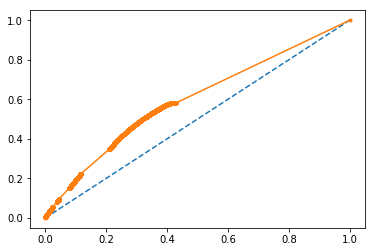

In [32]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [104]:
train_all = x_train

In [105]:
train_all.columns

Index(['has_name_change', 'delta_qty_issued_credit_reports',
       'delta_score_payment_assessment', 'code_legal_form_has_changed',
       'SBI_has_changed', 'company_age', 'qty_green_flags', 'qty_orange_flags',
       'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC',
       'D', 'NR', 'code_legal_form_group_1', 'code_legal_form_group_2',
       'SBI_group_1', 'SBI_group_2', 'is_discontinued_any',
       'has_financial_calamity', 'mean_qty_issued_credit_reports',
       'mean_score_payment_assessment', 'qty_address_mutations_year',
       'qty_started_names_year', 'qty_stopped_names_year',
       'qty_board_changes_year', 'variance_qty_issued_credit_reports',
       'variance_score_payment_assessment', 'variance_score_pd'],
      dtype='object')

In [106]:
train_all['has_relocated_next_year'] = y_train

In [107]:
train_all.shape

(4537409, 36)

In [108]:
train_all.has_relocated_next_year.value_counts() / train_all.shape[0]

0    0.95873
1    0.04127
Name: has_relocated_next_year, dtype: float64

In [109]:
# Choose desired class breakdown
fraction_majority = 0.50

In [110]:
num_minority = train_all[train_all['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(187261, 187261, 187261.0, 0.5)

In [111]:
# Separate majority and minority classes
df_majority = train_all[train_all.has_relocated_next_year==False]
df_minority = train_all[train_all.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

1    187261
0    187261
Name: has_relocated_next_year, dtype: int64

In [112]:
df_downsampled.has_relocated_next_year.value_counts()/df_downsampled.shape[0]

1    0.5
0    0.5
Name: has_relocated_next_year, dtype: float64

In [113]:
df_downsampled.shape

(374522, 36)

In [114]:
data_df.shape

(5787251, 59)

## Remove NaNs from Balanced Dataset:

In [115]:
data_to_model = df_downsampled[features_in_model + ['has_relocated_next_year']]

In [116]:
data_to_model.shape

(374522, 36)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [117]:
data_to_model.isnull().values.any()

False

In [118]:
print(data_to_model.isnull().sum())

has_name_change                       0
delta_qty_issued_credit_reports       0
delta_score_payment_assessment        0
code_legal_form_has_changed           0
SBI_has_changed                       0
company_age                           0
qty_green_flags                       0
qty_orange_flags                      0
qty_red_flags                         0
A                                     0
AA                                    0
AAA                                   0
B                                     0
BB                                    0
BBB                                   0
C                                     0
CC                                    0
CCC                                   0
D                                     0
NR                                    0
code_legal_form_group_1               0
code_legal_form_group_2               0
SBI_group_1                           0
SBI_group_2                           0
is_discontinued_any                   0


Drop rows with NA:

In [80]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(180434, 40)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
data_to_model.isnull().values.any()

False

<a id='dt_rebalance'></a>

# Random Forest on Re-balanced data

<a href=#top>Top</a>

In [119]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

y_re_train=y_re_train.astype('int')
y_re_test=y_re_test.astype('int')

In [120]:
x_train.shape

(4537409, 36)

In [121]:
x_re_train.shape

(280891, 35)

In [122]:
clf = RandomForestClassifier(n_estimators=100, max_depth=6,random_state=0, min_samples_split=5)

clf.fit(x_re_train, y_re_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [124]:
clf = RandomForestClassifier()

clf.fit(x_re_train, y_re_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.906 



In [123]:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.624 



## Save Model

In [126]:
filename = 'models/RF_defaults_balanced.sav'
pickle.dump(clf, open(filename, 'wb'))

## Model Tuning:

In [158]:
RandomForestClassifier?

In [160]:
x_train.shape

(4537409, 36)

In [163]:
#parameters = {'n_estimators':range(50,120)}

parameters = {'max_depth':range(15, 25), 'min_samples_leaf':[5, 10, 15], 'min_samples_split':range(2, 10)}
clfB = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=4)
clfB.fit(X=x_re_train, y=y_re_train)
clf_RF = clfB.best_estimator_
print (clfB.best_score_, clfB.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6407681271382849 {'min_samples_split': 7, 'max_depth': 21, 'min_samples_leaf': 15}


In [165]:
filename = 'models/RF_md15_25_msl5_15_mss2_10_balanced.sav'
pickle.dump(clf_RF, open(filename, 'wb'))

In [166]:
y_re_pred=clf_RF.predict(x_re_test)

In [170]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[25323, 21839],
       [11526, 34943]])

In [173]:
score=metrics.accuracy_score(y_re_test, y_re_pred)

# Get probabilities
y_re_probs = clf_RF.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

In [174]:
score, auc, kappa

(0.6436543452489026, 0.7038267694654605, 0.2884298935532571)

In [130]:
score, auc, kappa

(0.6127671390885497, 0.6623778148516803, 0.22538909741547575)

In [131]:
print(cr)

              precision    recall  f1-score   support

           0       0.61      0.62      0.62     47162
           1       0.61      0.60      0.61     46469

   micro avg       0.61      0.61      0.61     93631
   macro avg       0.61      0.61      0.61     93631
weighted avg       0.61      0.61      0.61     93631



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


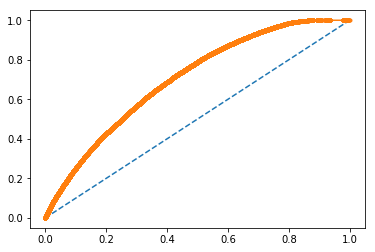

In [175]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

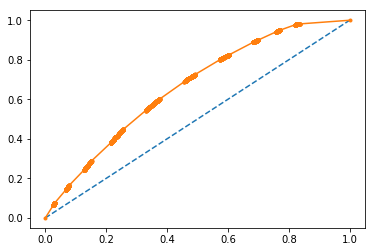

In [132]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

## Verify on Un-balanced test set:

<a href=#top>Top</a>

In [133]:
x_test.shape

(1134353, 35)

In [176]:
y_re_pred_unbalance=clf_RF.predict(x_test)

In [135]:
y_re_pred_unbalance.shape

(1134353,)

In [136]:
cnf_matrix = metrics.confusion_matrix(y_test, y_re_pred_unbalance)
cnf_matrix

array([[677794, 409562],
       [ 18701,  28296]])

In [156]:
sum(y_test) / len(y_test), sum(y_test==0) / len(y_test) 

(0.04143066576277402, 0.958569334237226)

In [177]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.47411960827008875, 0.5258803917299112)

In [157]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.3859980094379792, 0.6140019905620209)

In [178]:
score=metrics.accuracy_score(y_test, y_re_pred_unbalance)

# Get probabilities
y_re_probs = clf_RF.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_test, y_re_pred_unbalance)
cr=metrics.classification_report(y_test, y_re_pred_unbalance)

In [179]:
score, auc, kappa

(0.54659263915201, 0.7033809747910406, 0.047991716204711876)

In [138]:
score, auc, kappa

(0.6224605568107987, 0.6622682287575188, 0.04527798222695878)

In [139]:
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.62      0.76   1087356
           1       0.06      0.60      0.12     46997

   micro avg       0.62      0.62      0.62   1134353
   macro avg       0.52      0.61      0.44   1134353
weighted avg       0.94      0.62      0.73   1134353



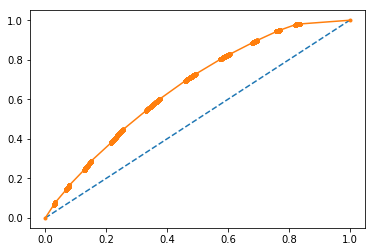

In [140]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

NameError: name 'plt' is not defined

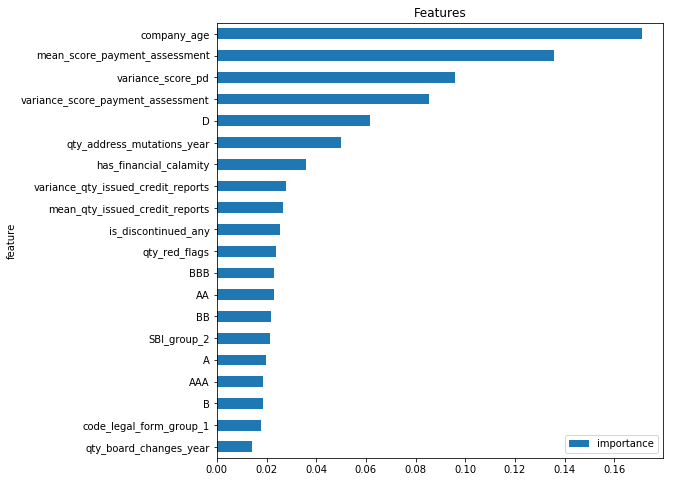

In [169]:
feat_imp = pd.DataFrame({'importance':clf_RF.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:20]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()